# Vehicle Detection Workbook

## Color Space Exploration

Here we'll plot various color space representations of three test car images and three test non-car images to see which color space shows usable differences that can help with detecting between cars and non-cars.

In [1]:
from math import ceil
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog

In [2]:
def plot3d(images, cspace, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    fig = plt.figure(figsize=(18, 5))
    col = 0
    for image in images:
        col += 1
        img = cv2.imread("test_images/" + image)

        # Read a color image
        # img = cv2.imread("test_images/25.png")

        # Select a small fraction of pixels to plot by subsampling it
        scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
        img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

        # Convert subsampled image to desired color space(s)
        img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
        img_small_PLOT = cv2.cvtColor(img_small, cspace)
        img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

        pixels = img_small_PLOT
        colors_rgb = img_small_rgb

        # Create figure and 3D axes
        ax = fig.add_subplot(1, len(images), col, projection='3d')

        # Set axis limits
        ax.set_xlim(*axis_limits[0])
        ax.set_ylim(*axis_limits[1])
        ax.set_zlim(*axis_limits[2])

        # Set axis labels and sizes
        ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
        ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
        ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
        ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

        # Plot pixel values with colors given in colors_rgb
        ax.scatter(
            pixels[:, :, 0].ravel(),
            pixels[:, :, 1].ravel(),
            pixels[:, :, 2].ravel(),
            c=colors_rgb.reshape((-1, 3)), edgecolors='none')

        ax.set_title(''.join(axis_labels) + " " + image)



    
def plot_images(images, names, images_per_row, figure_size, cmap='viridis'):
    
    fig = plt.figure(figsize=figure_size)
    row_count = ceil(len(images) / images_per_row)
    row = 1
    col = 0
    index = 0
    for img in images:
        col += 1
        ax = fig.add_subplot(row, len(images), col)
        ax.set_title(names[index])
        ax.imshow(img, cmap=cmap)
        index += 1
        if col == images_per_row:
            col = 0
            row += 1
    plt.show()


For each color space, the top three images are cars, and the bottom three are non-cars.  The car and non-car images are shown below:

In [3]:
car_images = []
not_images = []

cars = ["25.png", "31.png", "53.png"]
not_cars = ["2.png", "3.png", "8.png"]

for car in cars:
    car_images.append(mpimg.imread('test_images/' + car))
    
for not_car in not_cars:
    not_images.append(mpimg.imread('test_images/' + not_car))

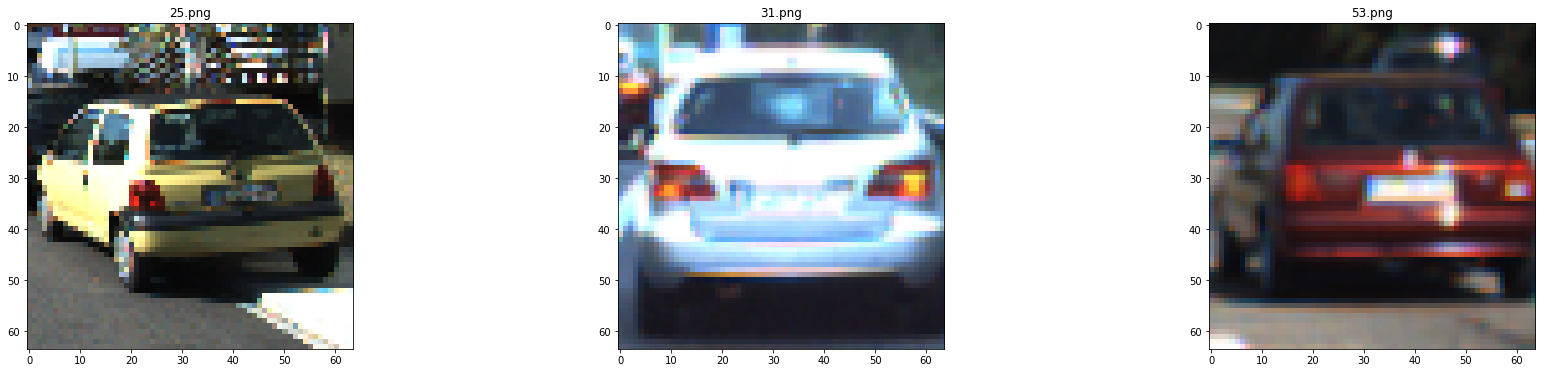

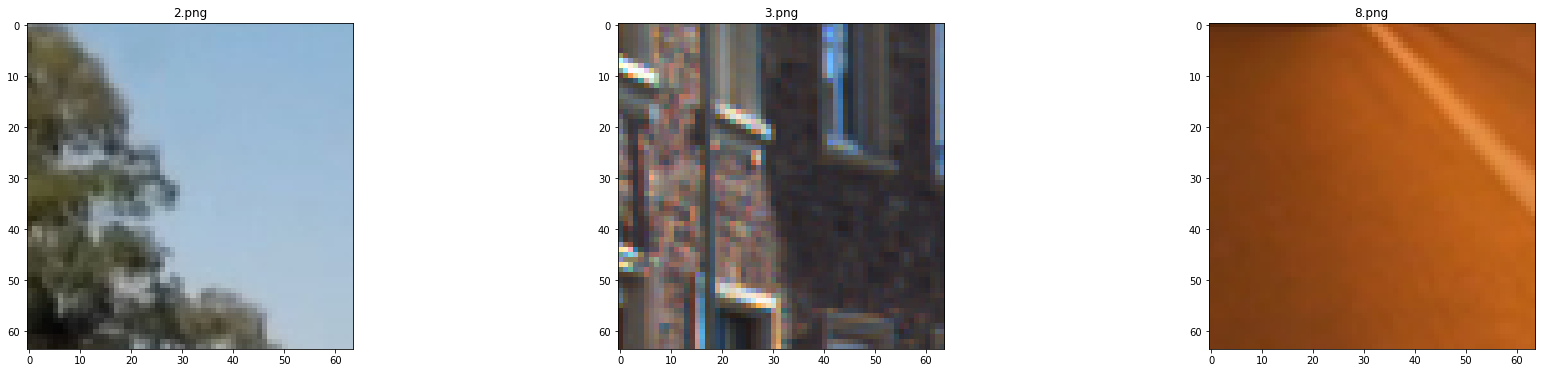

In [4]:
plot_images(car_images, cars, 3, (30, 6))
plot_images(not_images, not_cars, 3, (30, 6))


### RGB

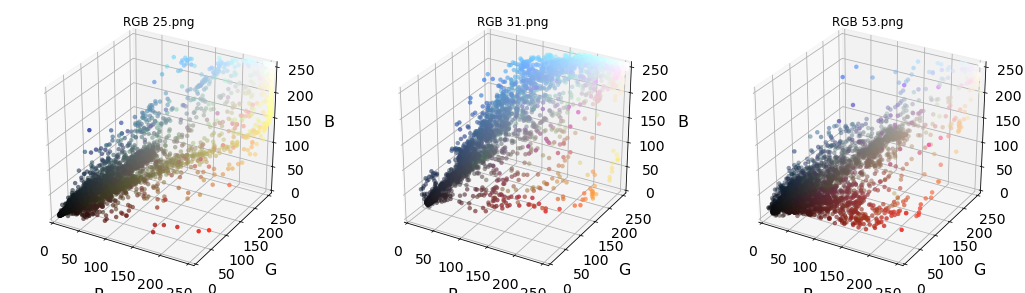

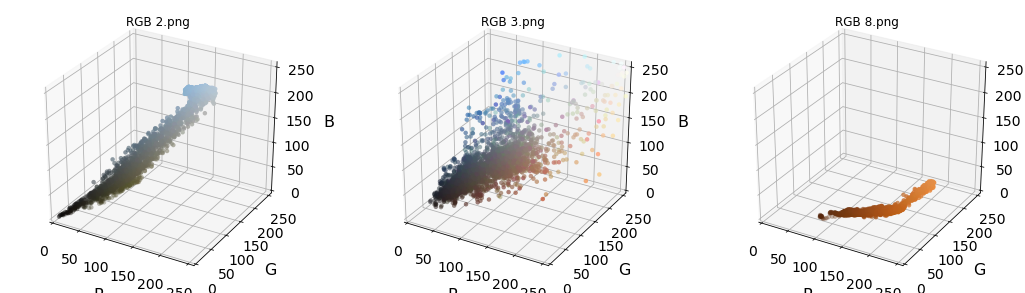

In [5]:
# Plot and show
cspace = cv2.COLOR_BGR2RGB
plot3d(cars, cspace)
plt.show()

plot3d(not_cars, cspace)
plt.show()

### HSV

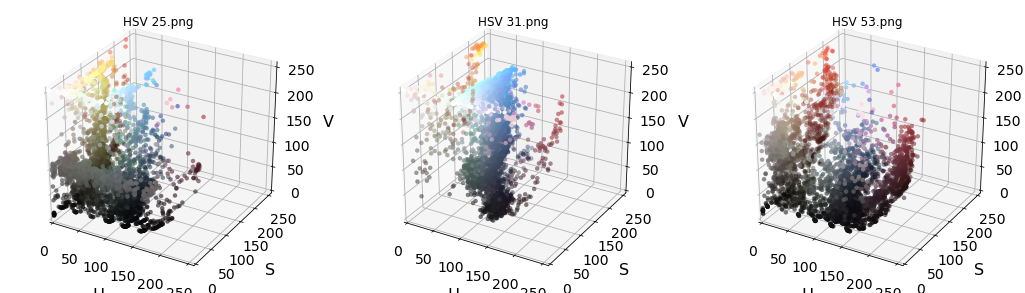

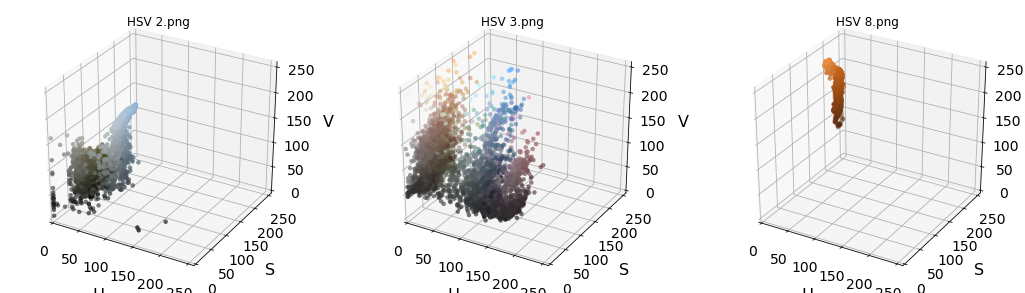

In [6]:
# Plot and show
cspace = cv2.COLOR_BGR2HSV
plot3d(cars, cspace, axis_labels=list("HSV"))
plt.show()

plot3d(not_cars, cspace, axis_labels=list("HSV"))
plt.show()

### HLS

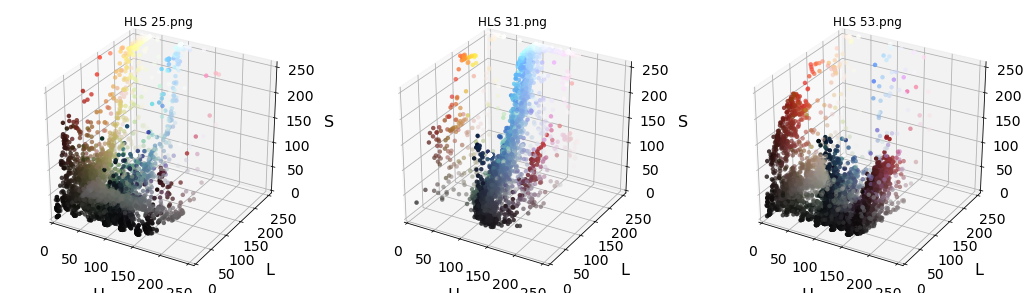

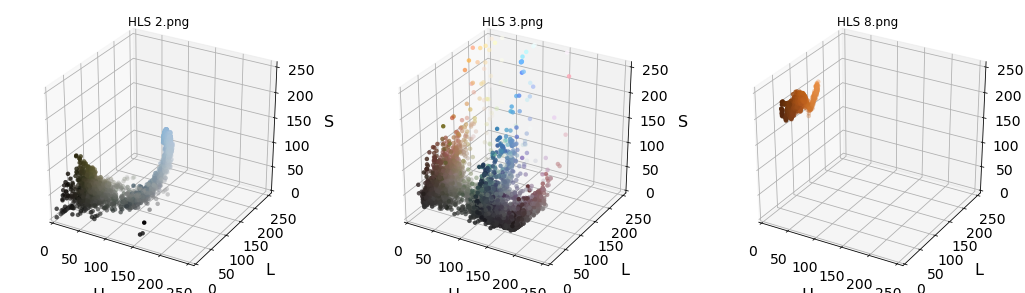

In [7]:
# Plot and show
cspace = cv2.COLOR_BGR2HLS
plot3d(cars, cspace, axis_labels=list("HLS"))
plt.show()

plot3d(not_cars, cspace, axis_labels=list("HLS"))
plt.show()

### YUV

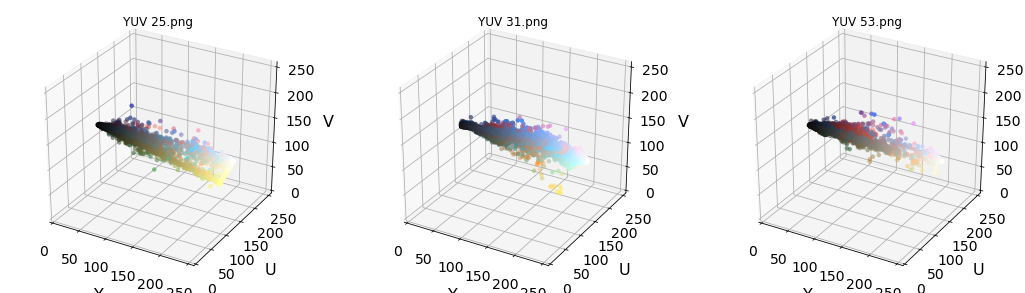

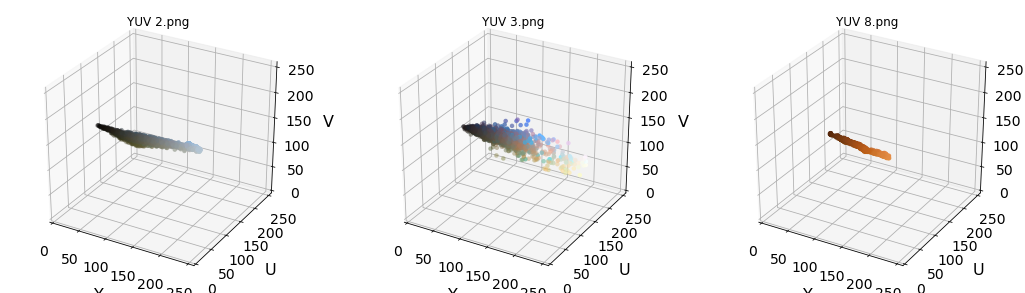

In [8]:
# Plot and show
cspace = cv2.COLOR_BGR2YUV
plot3d(cars, cspace, axis_labels=list("YUV"))
plt.show()

plot3d(not_cars, cspace, axis_labels=list("YUV"))
plt.show()

### LUV

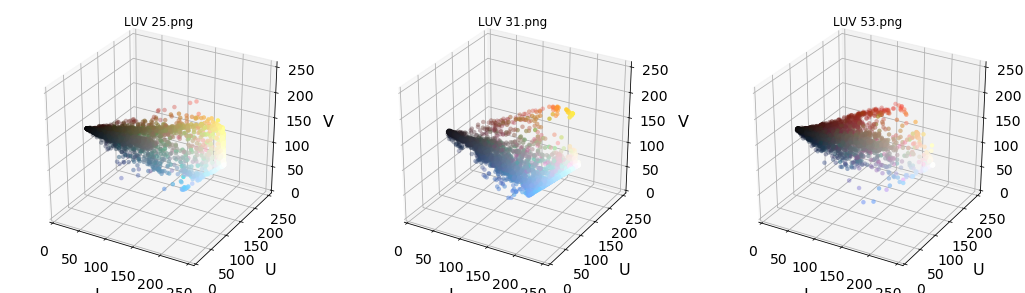

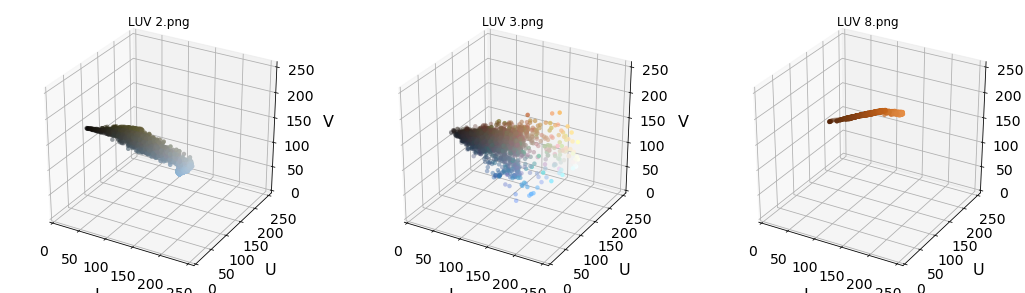

In [9]:
# Plot and show
cspace = cv2.COLOR_BGR2LUV
plot3d(cars, cspace, axis_labels=list("LUV"))
plt.show()

plot3d(not_cars, cspace, axis_labels=list("LUV"))
plt.show()

### YCrCb

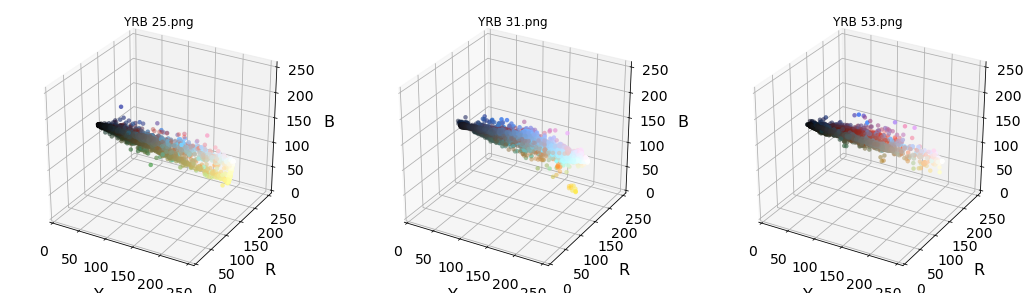

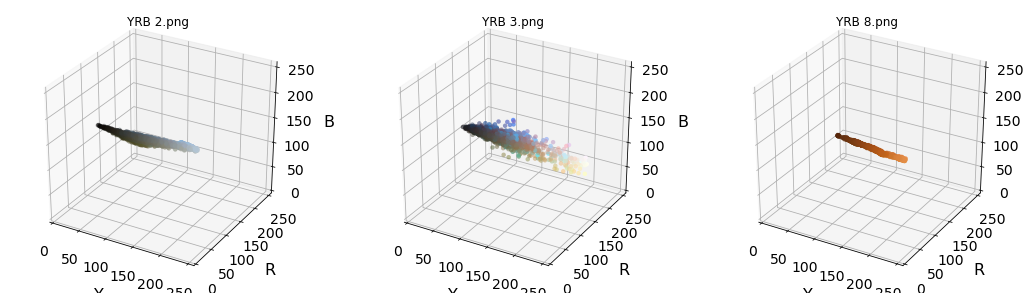

In [10]:
# Plot and show
cspace = cv2.COLOR_BGR2YCrCb
plot3d(cars, cspace, axis_labels=list("YRB"))
plt.show()

plot3d(not_cars, cspace, axis_labels=list("YRB"))
plt.show()

## Feature Vector

In this section we explore extracting histogram features from the color information of cars and non-cars.

In [11]:
# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
image = mpimg.imread('test_images/cutout1.jpg')

def convert_colorspace(img, color_space):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
    return feature_image

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    feature_image = convert_colorspace(img, color_space)       
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

def plot_features(images, color_space='RGB', size=(32, 32)):
    
    fig = plt.figure(figsize=(18, 5))
    col = 0
    for image_name in images:
        col += 1
        image = mpimg.imread('test_images/' + image_name)

        feature_vec = bin_spatial(image, color_space, size)
        ax = fig.add_subplot(1, len(images), col)
        ax.set_title(color_space + " " + image_name)
        ax.plot(feature_vec)


The top three images for each color space are cars.  The bottom three images for each color space are non-cars.

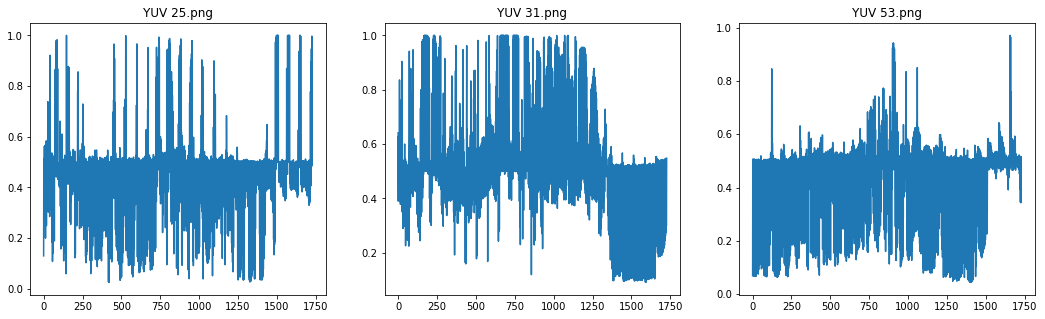

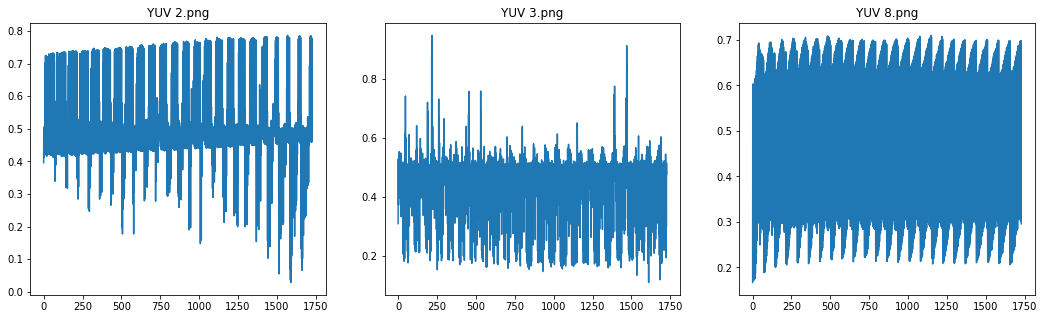

In [12]:
#YUV
cspace='YUV'
plot_features(cars, cspace, size=(24,24))
plt.show()
plot_features(not_cars, cspace, size=(24,24))
plt.show()


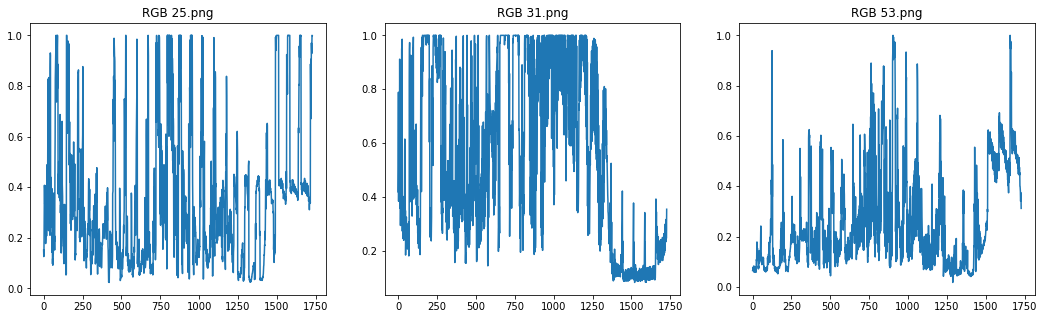

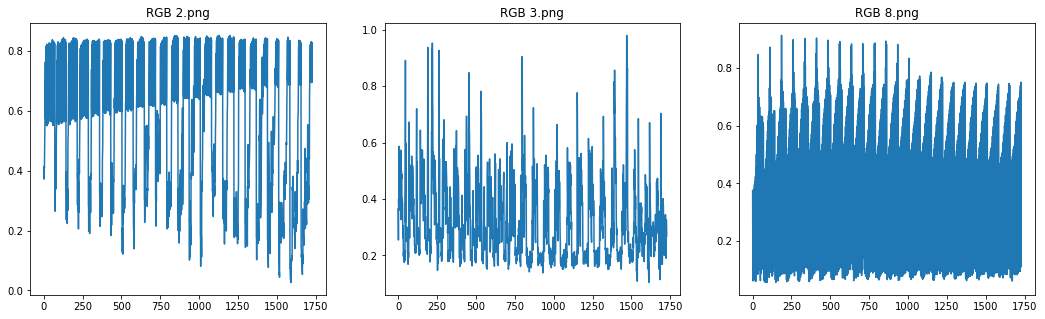

In [13]:
#RGB
cspace='RGB'
plot_features(cars, cspace, size=(24,24))
plt.show()
plot_features(not_cars, cspace, size=(24,24))
plt.show()


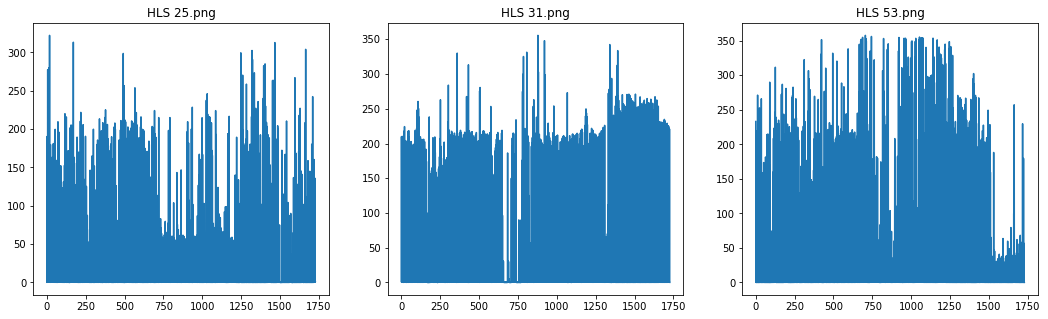

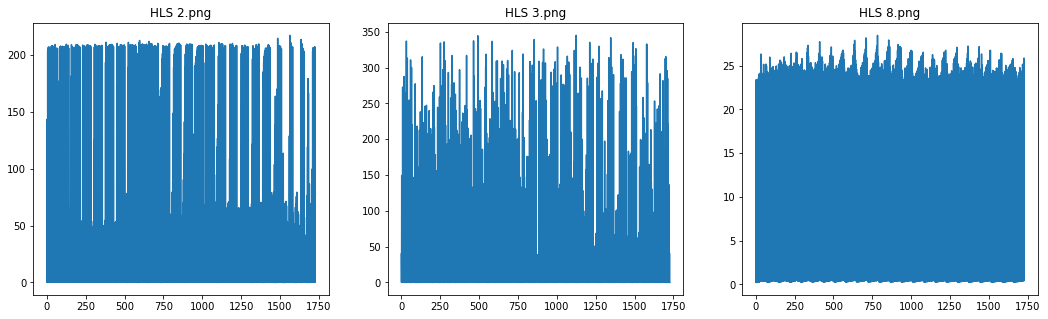

In [14]:
#HLS
cspace='HLS'
plot_features(cars, cspace, size=(24,24))
plt.show()
plot_features(not_cars, cspace, size=(24,24))
plt.show()

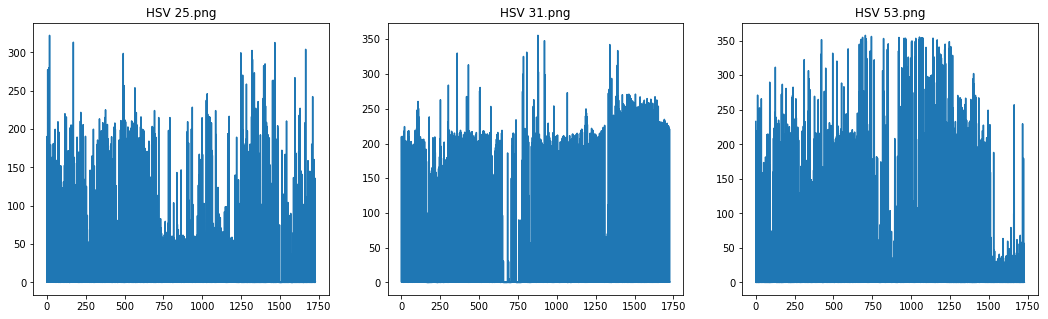

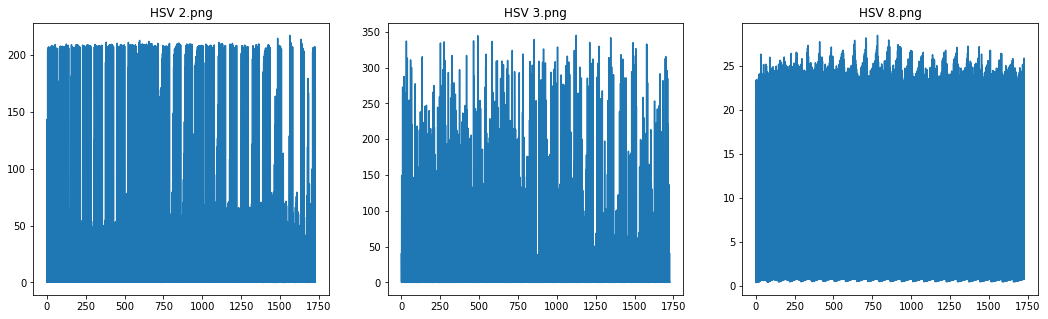

In [15]:
#HSV
cspace='HSV'
plot_features(cars, cspace, size=(24,24))
plt.show()
plot_features(not_cars, cspace, size=(24,24))
plt.show()

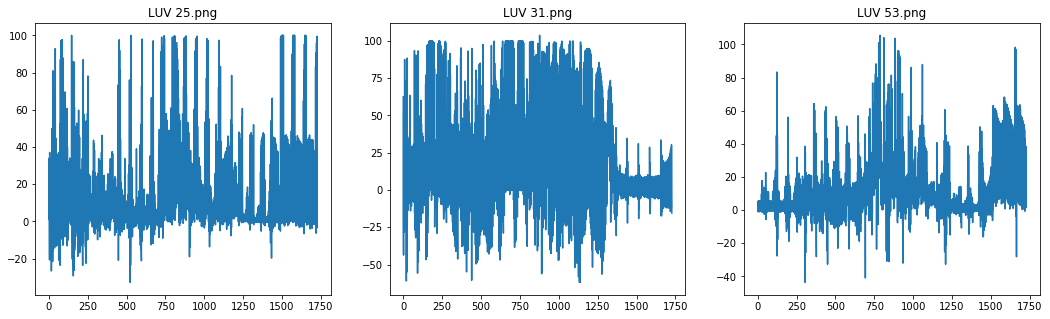

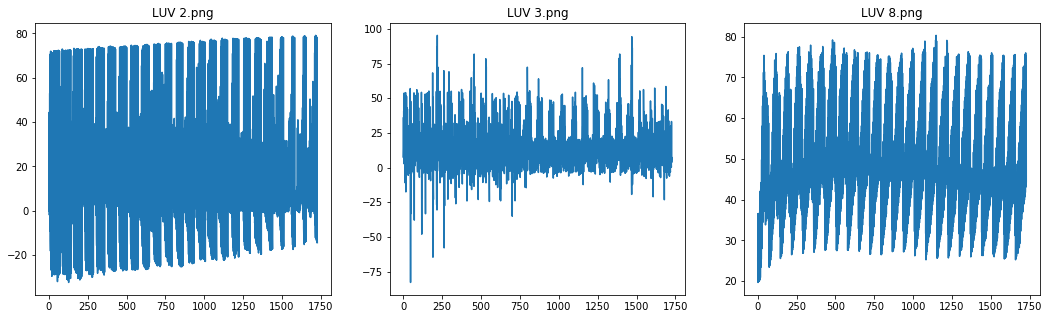

In [16]:
#LUV
cspace='LUV'
plot_features(cars, cspace, size=(24,24))
plt.show()
plot_features(not_cars, cspace, size=(24,24))
plt.show()

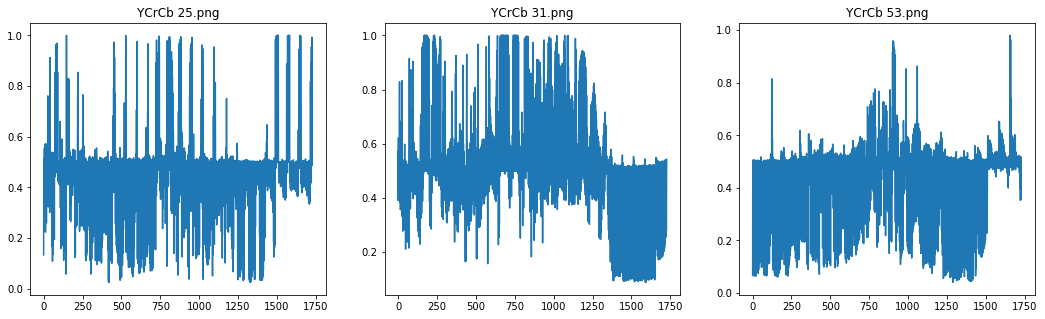

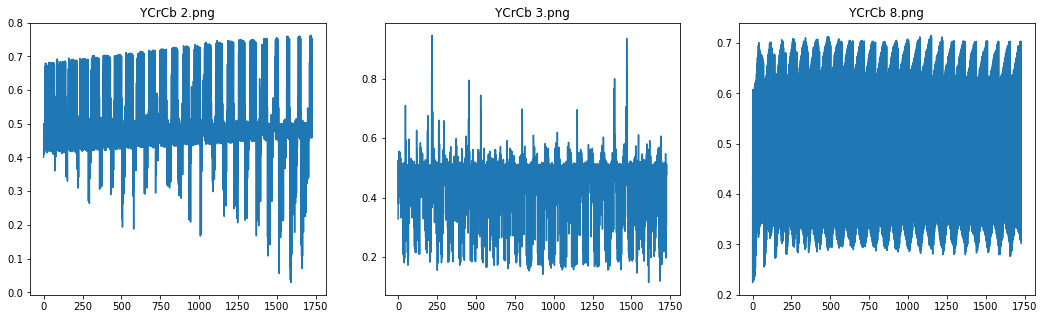

In [17]:
#YCrCb
cspace='YCrCb'
plot_features(cars, cspace, size=(24,24))
plt.show()
plot_features(not_cars, cspace, size=(24,24))
plt.show()

## HOG

Here we explore the use of *Histogram of Oriented Gradients* (HOG) features.

In [18]:
# Read in our vehicles and non-vehicles
images = glob.iglob('**/*.jpeg', recursive=True)
cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get features and hog image
        features, hog_image = hog(img, orientations=orient, \
            pixels_per_cell=(pix_per_cell, pix_per_cell), \
            cells_per_block=(cell_per_block, cell_per_block), \
            visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, \
            pixels_per_cell=(pix_per_cell, pix_per_cell), \
            cells_per_block=(cell_per_block, cell_per_block), \
            visualise=vis, feature_vector=feature_vec)
        features = [] # Remove this line
        return features

Below are some plots to visualize the HOG features from a car image and the associated feature histogram.

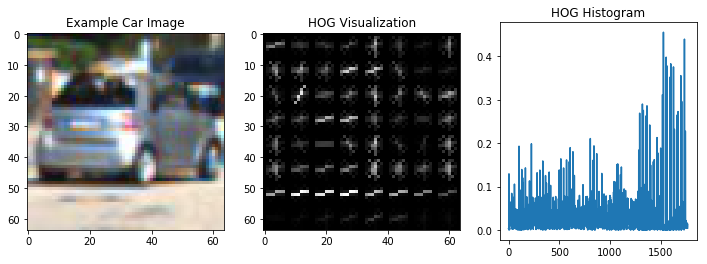

In [19]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)


# Plot the examples
fig = plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(133)
plt.plot(features)
plt.title('HOG Histogram')
plt.show()

And let's look at HOG features for a non-car image.

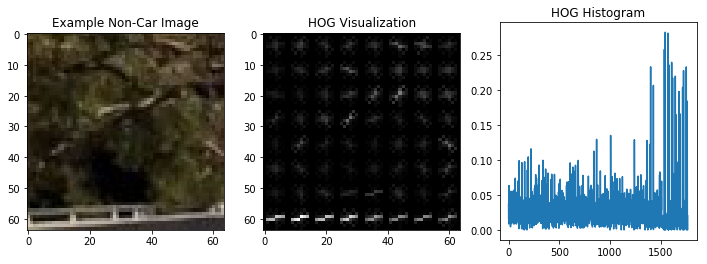

In [20]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(notcars))
# Read in the image
image = mpimg.imread(notcars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)


# Plot the examples
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.subplot(133)
plt.plot(features)
plt.title('HOG Histogram')
plt.show()

## Color Classify

In this section we try to discern between cars and non-cars using just the color histogram features with different values for the size of the spatial bins and histogram bins.

In [21]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

In [22]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


# Read in car and non-car images
images = glob.iglob('**/*.jpeg', recursive=True)
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

def classify(spatial, histbin):
    car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256))
    notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                            hist_bins=histbin, hist_range=(0, 256))

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using spatial binning of:',spatial,
        'and', histbin,'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    
classify(32, 32)

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
2.61 Seconds to train SVC...
Test Accuracy of SVC =  0.9935
My SVC predicts:  [ 1.  1.  0.  1.  1.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  1.  0.  1.  1.  0.]
0.003 Seconds to predict 10 labels with SVC


In [23]:
classify(16, 32)

Using spatial binning of: 16 and 32 histogram bins
Feature vector length: 864
0.38 Seconds to train SVC...
Test Accuracy of SVC =  0.9914
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  1.  0.  1.  1.]
0.00271 Seconds to predict 10 labels with SVC


In [24]:
classify(32, 16)

Using spatial binning of: 32 and 16 histogram bins
Feature vector length: 3120
2.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9634
My SVC predicts:  [ 1.  0.  1.  1.  0.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  0.  0.  1.  0.  1.  1.]
0.00291 Seconds to predict 10 labels with SVC


In [25]:
classify(16, 16)

Using spatial binning of: 16 and 16 histogram bins
Feature vector length: 816
0.52 Seconds to train SVC...
Test Accuracy of SVC =  0.9699
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  0.  0.  1.  1.]
0.00315 Seconds to predict 10 labels with SVC


In [26]:
classify(8, 32)

Using spatial binning of: 8 and 32 histogram bins
Feature vector length: 288
0.12 Seconds to train SVC...
Test Accuracy of SVC =  0.9892
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  1.  0.  0.  1.]
0.00341 Seconds to predict 10 labels with SVC


In [27]:
classify(8, 48)

Using spatial binning of: 8 and 48 histogram bins
Feature vector length: 336
0.14 Seconds to train SVC...
Test Accuracy of SVC =  0.9871
My SVC predicts:  [ 0.  1.  1.  1.  0.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  0.  0.  0.  1.  0.]
0.00278 Seconds to predict 10 labels with SVC


In [28]:
classify(16, 48)

Using spatial binning of: 16 and 48 histogram bins
Feature vector length: 912
0.42 Seconds to train SVC...
Test Accuracy of SVC =  0.9914
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  1.]
0.00281 Seconds to predict 10 labels with SVC


In [29]:
classify(32, 48)

Using spatial binning of: 32 and 48 histogram bins
Feature vector length: 3216
2.16 Seconds to train SVC...
Test Accuracy of SVC =  0.9849
My SVC predicts:  [ 1.  1.  1.  0.  0.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  0.  0.  1.  0.  1.]
0.00281 Seconds to predict 10 labels with SVC


In [30]:
classify(8, 60)

Using spatial binning of: 8 and 60 histogram bins
Feature vector length: 372
0.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9849
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  0.  0.  1.  1.]
0.00331 Seconds to predict 10 labels with SVC


In [31]:
classify(32, 32)

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
2.58 Seconds to train SVC...
Test Accuracy of SVC =  0.9892
My SVC predicts:  [ 0.  1.  1.  1.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  0.  1.  0.  0.  1.]
0.0032 Seconds to predict 10 labels with SVC


In [32]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


# Divide up into cars and notcars
images = glob.iglob('**/*.jpeg', recursive=True)
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

def hog_classify(colorspace, orient, pix_per_cell, cell_per_block, hog_channel):
    t=time.time()
    car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [33]:
hog_classify('RGB', 9, 8, 2, 0)

2.22 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.06 Seconds to train SVC...
Test Accuracy of SVC =  0.96
My SVC predicts:  [ 1.  1.  1.  0.  0.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  0.  1.  0.  0.  0.  0.]
0.00213 Seconds to predict 10 labels with SVC


In [34]:
hog_classify('YUV', 9, 8, 2, 0)

2.28 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.07 Seconds to train SVC...
Test Accuracy of SVC =  0.99
My SVC predicts:  [ 0.  0.  1.  1.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  0.  0.  0.  1.  0.]
0.00248 Seconds to predict 10 labels with SVC


In [35]:
hog_classify('HLS', 9, 8, 2, 0)

2.29 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.07 Seconds to train SVC...
Test Accuracy of SVC =  0.975
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  0.  0.  1.]
0.00248 Seconds to predict 10 labels with SVC


In [36]:
hog_classify('YCrCb', 9, 8, 2, 0)

2.22 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.07 Seconds to train SVC...
Test Accuracy of SVC =  0.99
My SVC predicts:  [ 0.  1.  1.  0.  1.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  1.  1.  1.]
0.00264 Seconds to predict 10 labels with SVC


In [37]:
hog_classify('LUV', 9, 8, 2, 0)

2.36 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.07 Seconds to train SVC...
Test Accuracy of SVC =  0.975
My SVC predicts:  [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  0.  0.  0.  1.  1.]
0.00318 Seconds to predict 10 labels with SVC


In [38]:
hog_classify('HSV', 9, 8, 2, 0)

2.28 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
0.06 Seconds to train SVC...
Test Accuracy of SVC =  0.975
My SVC predicts:  [ 1.  0.  1.  1.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  1.  0.  0.  0.  1.  0.  0.]
0.00335 Seconds to predict 10 labels with SVC


In [39]:
hog_classify('LUV', 9, 4, 2, 0)

5.36 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 8100
0.28 Seconds to train SVC...
Test Accuracy of SVC =  0.99
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  1.  1.  0.  1.]
0.00312 Seconds to predict 10 labels with SVC


In [40]:
hog_classify('LUV', 12, 4, 2, 0)

5.46 Seconds to extract HOG features...
Using: 12 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 10800
0.36 Seconds to train SVC...
Test Accuracy of SVC =  0.975
My SVC predicts:  [ 1.  0.  0.  1.  1.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  1.  0.  0.  1.  0.]
0.00999 Seconds to predict 10 labels with SVC


In [41]:
hog_classify('LUV', 6, 4, 2, 0)

5.27 Seconds to extract HOG features...
Using: 6 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 5400
0.22 Seconds to train SVC...
Test Accuracy of SVC =  0.975
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
0.00319 Seconds to predict 10 labels with SVC


In [42]:
hog_classify('LUV', 9, 4, 2, 1)

5.37 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 8100
0.23 Seconds to train SVC...
Test Accuracy of SVC =  0.965
My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  1.]
0.00323 Seconds to predict 10 labels with SVC


In [43]:
hog_classify('LUV', 9, 4, 2, 2)

5.47 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 8100
0.24 Seconds to train SVC...
Test Accuracy of SVC =  0.985
My SVC predicts:  [ 0.  0.  1.  0.  1.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  1.  1.  1.  1.  0.]
0.00316 Seconds to predict 10 labels with SVC


In [44]:
hog_classify('LUV', 9, 4, 2, 'ALL')

14.86 Seconds to extract HOG features...
Using: 9 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 24300
0.7 Seconds to train SVC...
Test Accuracy of SVC =  0.99
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  0.]
0.00264 Seconds to predict 10 labels with SVC


In [45]:
hog_classify('LUV', 6, 4, 2, 'ALL')

14.93 Seconds to extract HOG features...
Using: 6 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 16200
0.43 Seconds to train SVC...
Test Accuracy of SVC =  0.995
My SVC predicts:  [ 0.  0.  1.  1.  1.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  0.  1.  0.  1.  1.]
0.00337 Seconds to predict 10 labels with SVC


In [46]:
hog_classify('LUV', 9, 8, 2, 'ALL')

6.04 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
0.13 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  0.  0.  1.  1.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  1.  0.  0.  1.  0.]
0.00236 Seconds to predict 10 labels with SVC


### Test Accuracy = 1.0 with LUV, 9 orientations, 4 pixels per cell, and 2 pixels per cell block, but 8 pixels per cell is nearly as accurate at test accuracy = 0.995.

## Sliding Windows

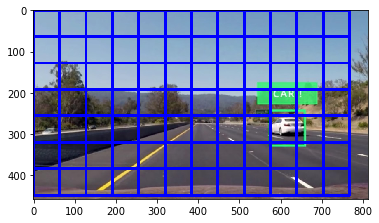

In [47]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('test_images/bbox_example_image.jpg')

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    height = img.shape[0]
    width = img.shape[1]
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None: x_start_stop[0] = 0
    if x_start_stop[1] is None: x_start_stop[1] = width
    if y_start_stop[0] is None: y_start_stop[0] = 0
    if y_start_stop[1] is None: y_start_stop[1] = height
    
    # Compute the span of the region to be searched
    search_span = [x_start_stop[1] - x_start_stop[0], y_start_stop[1] - y_start_stop[0]]
    # Compute the number of pixels per step in x/y
    x_step = np.int((1.0 - xy_overlap[0]) * xy_window[0])
    y_step = np.int((1.0 - xy_overlap[1]) * xy_window[1])

    # Compute the number of windows in x/y
    x_windows = np.int((search_span[0] - x_step) / x_step)
    y_windows = np.int((search_span[1] - y_step) / y_step)

    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for y in range(y_windows):
        sy = y_start_stop[0] + y * y_step
        ey = sy + xy_window[1]
        for x in range(x_windows):
            # Calculate each window position
            sx = x_start_stop[0] + x * x_step
            ex = sx + xy_window[0]
            bbox = ((sx, sy), (ex, ey))
            # Append window position to list
            window_list.append(bbox)
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

In [48]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [49]:

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


## Search Classify

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
0.18 Seconds to train SVC...
Test Accuracy of SVC =  0.97


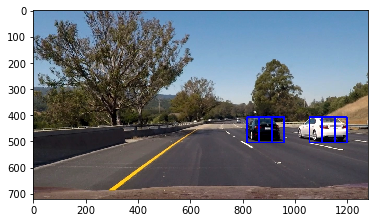

In [50]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
# Read in cars and notcars
#images = glob.glob('*small*/**/*.jpeg')
images = glob.glob('vehicles/**/*.png')
non_veh = glob.glob('non-vehicles/**/*.png')
images.extend(non_veh)

all_cars = []
all_notcars = []
for image in images:
    if 'non-vehicles' in image:
        all_notcars.append(image)
    else:
        all_cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, None] # Min and max in y to search in slide_window()

def full_classify(image_name, color_space=color_space, orient=orient, pix_per_cell=pix_per_cell, 
                  cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_size=spatial_size,
                  hist_bins=hist_bins, spatial_feat=spatial_feat, hist_feat=hist_feat,
                  hog_feat=hog_feat, y_start_stop=y_start_stop, sample_size=sample_size):
    cars = all_cars[0:sample_size]
    notcars = all_notcars[0:sample_size]    
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample

    image = mpimg.imread(image_name)
    draw_image = np.copy(image)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    return draw_image, hot_windows

def draw_result(image, windows):
    window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)
    plt.show()


image_name = 'test_images/test6.jpg'
draw_image, hot_windows = full_classify(image_name)
draw_result(draw_image, hot_windows)

Looks like just plain RGB with default parameters values (above) works well.

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
0.16 Seconds to train SVC...
Test Accuracy of SVC =  0.985


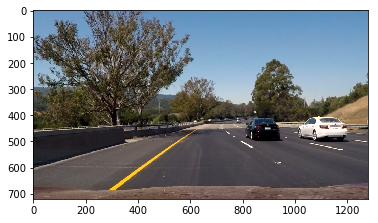

In [51]:
draw_image, hot_windows = full_classify(image_name, color_space='YUV')
draw_result(draw_image, hot_windows)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
0.1 Seconds to train SVC...
Test Accuracy of SVC =  0.995


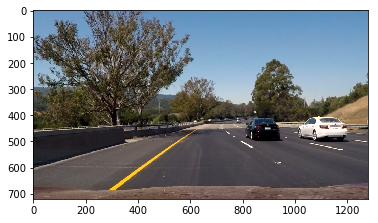

In [52]:
draw_image, hot_windows = full_classify(image_name, color_space='HLS')
draw_result(draw_image, hot_windows)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
0.08 Seconds to train SVC...
Test Accuracy of SVC =  0.995


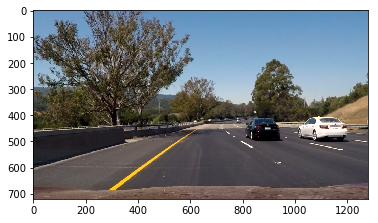

In [53]:
draw_image, hot_windows = full_classify(image_name, color_space='HSV')
draw_result(draw_image, hot_windows)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
0.13 Seconds to train SVC...
Test Accuracy of SVC =  0.99


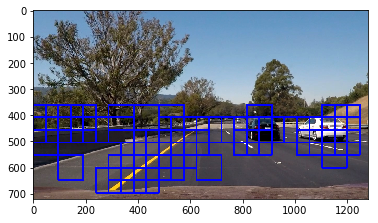

In [54]:
draw_image, hot_windows = full_classify(image_name, color_space='LUV')
draw_result(draw_image, hot_windows)

No hog features

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 816
0.23 Seconds to train SVC...
Test Accuracy of SVC =  0.99


/home/quoc/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


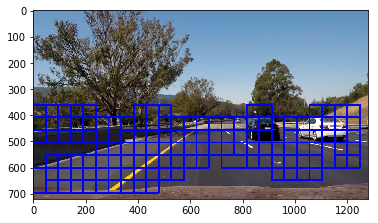

(None,)

In [55]:
draw_image, hot_windows = full_classify(image_name, color_space='LUV', hog_feat=False)
draw_result(draw_image, hot_windows),

No histogram features.

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2532
0.21 Seconds to train SVC...
Test Accuracy of SVC =  0.995


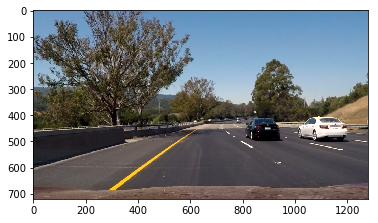

In [56]:
draw_image, hot_windows = full_classify(image_name, color_space='LUV', hist_feat=False)
draw_result(draw_image, hot_windows)

No spatial color features.

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1812
0.09 Seconds to train SVC...
Test Accuracy of SVC =  0.985


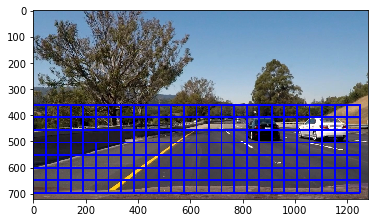

In [57]:
draw_image, hot_windows = full_classify(image_name, color_space='LUV', spatial_feat=False)
draw_result(draw_image, hot_windows)

Interesting results with no spatial features (above). Let's try using more samples with LUV and RGB.

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
5.67 Seconds to train SVC...
Test Accuracy of SVC =  0.9633


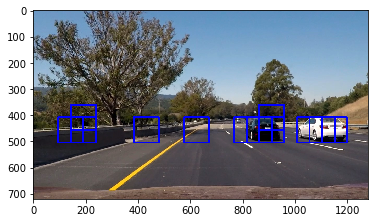

In [58]:
draw_image, hot_windows = full_classify(image_name, color_space='RGB', sample_size=3000)
draw_result(draw_image, hot_windows)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
3.68 Seconds to train SVC...
Test Accuracy of SVC =  0.9867


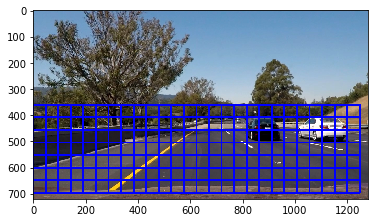

In [59]:
draw_image, hot_windows = full_classify(image_name, color_space='LUV', sample_size=3000)
draw_result(draw_image, hot_windows)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1812
2.8 Seconds to train SVC...
Test Accuracy of SVC =  0.9717


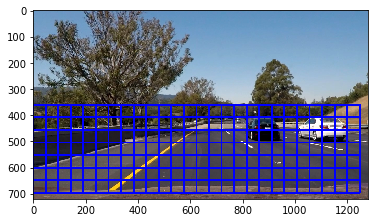

In [60]:
draw_image, hot_windows = full_classify(image_name, color_space='LUV', sample_size=3000, spatial_feat=False)
draw_result(draw_image, hot_windows)

No spatial features with LUV seems promising.

## Hog Sub-Sampling Window Search

In [61]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
29.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9896


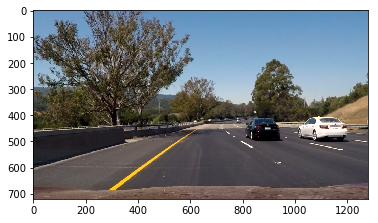

In [62]:
#from sklearn.svm import SVC

cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 1000)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
#print(svc)
'''
svc LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0)
'''
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()

svc LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
X_scaler StandardScaler(copy=True, with_mean=True, with_std=True)
orient 9
pix_per_cell 8
cell_per_block 2
spatial_size (32, 32)
hist_bins 32


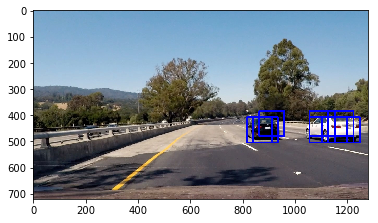

In [64]:
img = mpimg.imread('test_images/test4.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins, spatial_feat=spatial_feat):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            if spatial_feat:
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            else:
                test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 360
ystop = 656
scale = 1.5

print('svc', svc)
print('X_scaler', X_scaler)
print('orient', orient)
print('pix_per_cell', pix_per_cell)
print('cell_per_block', cell_per_block)
print('spatial_size', spatial_size)
print('hist_bins', hist_bins)
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()

In [65]:
test_images = ['test{}.jpg'.format(x) for x in range(1,7)]
print(test_images)

detect = []
for image_name in test_images:
    img = mpimg.imread('test_images/' + image_name)
    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins)
    detect.append(out_img)

['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


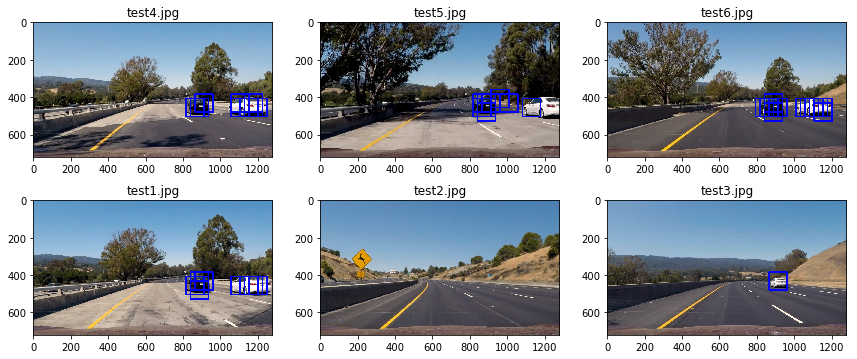

In [66]:
plot_images(detect, test_images, 3, (30,12))


for i, img in enumerate(detect):
    mpimg.imsave('output_images/' + test_images[i].replace('jpg', 'png'), img)

We reproduced the result from the lessons, so let's save the classifier and associated parameters for use in the actual project code.  We'll use the saved classifier in the project.  The function to save the classifier is below.

In [67]:
import pickle

def save_classifier(file_name):
    dist_pickle = {}
    dist_pickle["svc"] = svc
    dist_pickle["scaler"] = X_scaler
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hist_bins"] = hist_bins
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["hog_channel"] = hog_channel
    dist_pickle["spatial_feat"] = spatial_feat
    dist_pickle["hist_feat"] = hist_feat
    dist_pickle["hog_feat"] = hog_feat

    with open(file_name, 'wb') as file:
        pickle.dump(dist_pickle, file)

## Parameter Explorations

Trying out different parameters to see if we can get better result.  In particular, using spatial size of (8, 8) and 60 histogram bins showed better results in earlier color space exploration.

In [68]:
spatial_size = (8, 8)
hist_bins = 60
spatial_feat = True

In [69]:
from time import time
t = time()
car_features = extract_features(cars, color_space="LUV", 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space="LUV", 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
print('Elapsed time: {:.3f} seconds'.format(time() - t))

Elapsed time: 105.980 seconds


In [70]:
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 1000)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
#print(svc)
'''
svc LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0)
'''
# Check the training time for the SVC
t=time()
svc.fit(X_train, y_train)
t2 = time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5664
19.07 Seconds to train SVC...
Test Accuracy of SVC =  0.9907


In [71]:
detect = []
for image_name in test_images:
    img = mpimg.imread('test_images/' + image_name)
    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins)
    detect.append(out_img)
    
for i, img in enumerate(detect):
    mpimg.imsave('output_images/' + test_images[i].replace('.jpg', '_8_60.png'), img)    

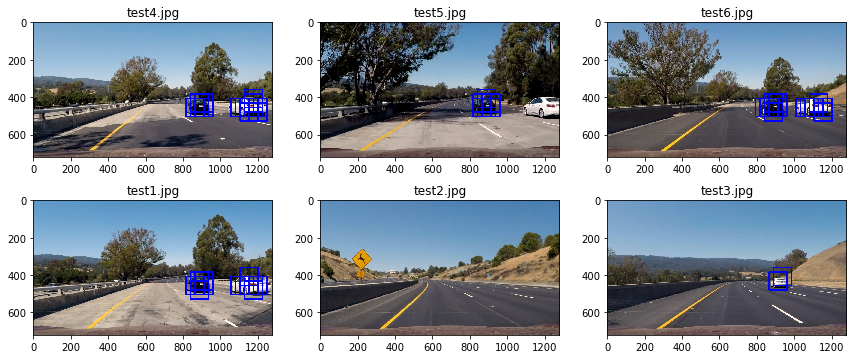

In [72]:
plot_images(detect, test_images, 3, (30,12))

Looks like comparable results to previous classifier. Let's save this classifier to use in the project also.

In [73]:
save_classifier("vehicle_classifer_8_60.p")

Will also try one more option with no spatial features since that worked well in earlier trials.

In [74]:
spatial_size = (8, 8)
hist_bins = 60
spatial_feat = False

In [75]:
car_features = extract_features(cars, color_space="LUV", 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space="LUV", 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

In [76]:
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 1000)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
#print(svc)
'''
svc LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0)
'''
# Check the training time for the SVC
t=time()
svc.fit(X_train, y_train)
t2 = time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5472
19.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9868


In [77]:
detect = []
for image_name in test_images:
    img = mpimg.imread('test_images/' + image_name)
    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins, spatial_feat)
    detect.append(out_img)
    
for i, img in enumerate(detect):
    mpimg.imsave('output_images/' + test_images[i].replace('.jpg', '_no_spatial.png'), img)

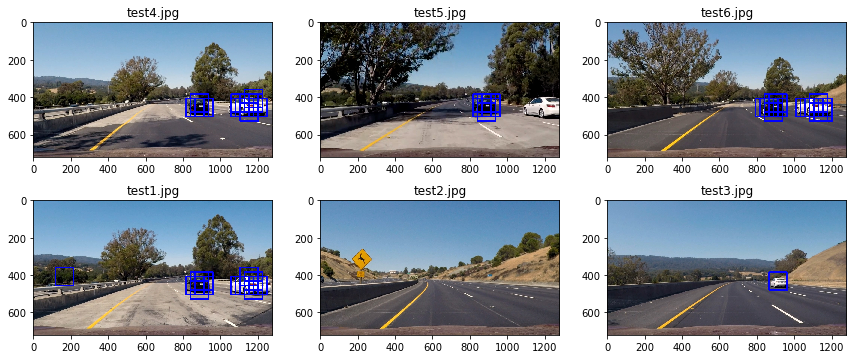

In [78]:
plot_images(detect, test_images, 3, (30,12))

Looks like spatial features does help to prevent some false positives to we'll keep it in.

## Multi-Scale Windows

Now we're ready to run the detection at different scales.  First, we'll load up the classifier, X_scaler, and other parameters that we'll use in the detection process.

In [79]:
with open("vehicle_classifer_8_60.p", 'rb') as file:
    dist_pickle = pickle.load(file)

svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
hog_channel = dist_pickle["hog_channel"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]


Modify the find_car method to return the detection rectangles.

In [80]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_car_rects(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins):
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rects = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                rects.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))) 
                
    return rects

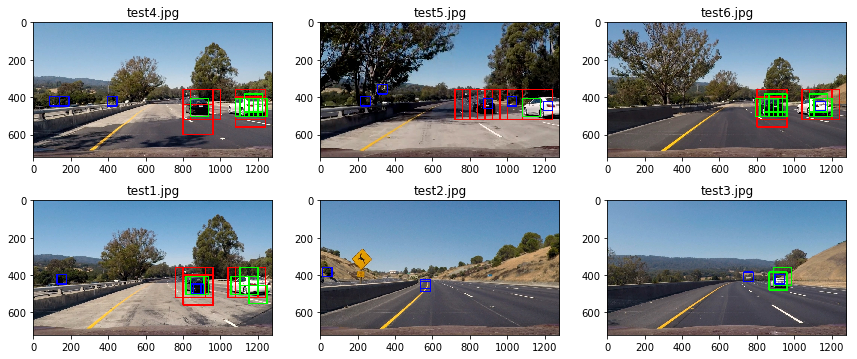

In [81]:
ystarts = [440, 360, 360, 320]
ystops = [720, 720, 656, 540]
scales = [3.5, 2.5, 1.5, 0.8]
colors = [(255,255,0), (255,0,0), (0,255,0), (0,0,255)]
line_size = 6

detect = []
bboxes = {}
for image_name in test_images:
    img = mpimg.imread('test_images/' + image_name)
    bboxes[image_name] = []
    for i in range(len(ystarts)):
        ystart = ystarts[i]
        ystop = ystops[i]
        scale = scales[i]

        rects = find_car_rects(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
            spatial_size, hist_bins)
        bboxes[image_name].extend(rects)

        for r in rects:
            cv2.rectangle(img, r[0], r[1], colors[i], line_size)

    detect.append(img)

plot_images(detect, test_images, 3, (30,12))

In [82]:
for i, img in enumerate(detect):
    mpimg.imsave('output_images/' + test_images[i].replace('.jpg', '_multiscale.png'), img)

## Heat Maps

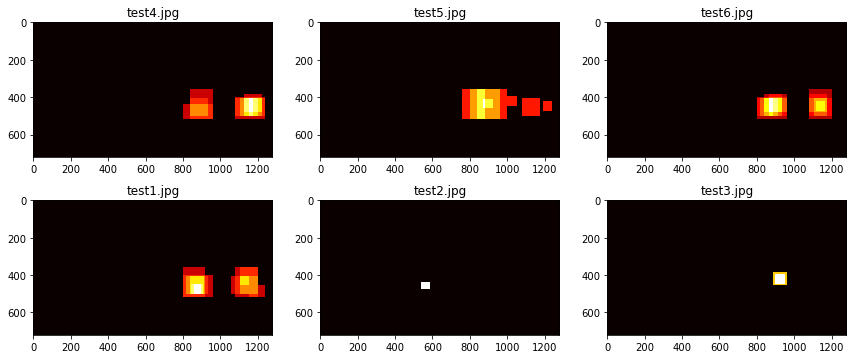

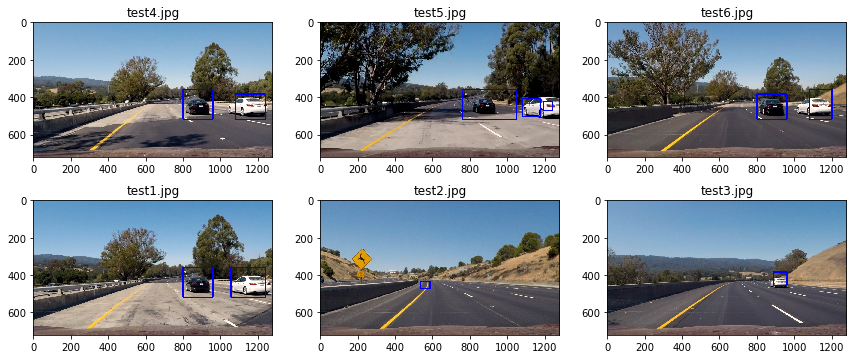

In [83]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat_images = []
box_images = []
for image_name in test_images:
    box_list = bboxes[image_name]

    # Read in image similar to one shown above 
    image = mpimg.imread('test_images/' + image_name)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)


    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    heat_images.append(heatmap)
    box_images.append(draw_img)
    
    
plot_images(heat_images, test_images, 3, (30,12), cmap='hot')
plot_images(box_images, test_images, 3, (30,12))

In [84]:
for i, img in enumerate(box_images):
    mpimg.imsave('output_images/' + test_images[i].replace('.jpg', '_bbox.png'), img)
    
for i, img in enumerate(heat_images):
    mpimg.imsave('output_images/' + test_images[i].replace('.jpg', '_heat.png'), img, cmap='hot')    